<a href="https://colab.research.google.com/github/3m6d/login-anomaly-isolation-forest/blob/main/Main_login_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/ritee/data.csv'

In [ ]:
import os

target_dir = "/content/drive/MyDrive/ritee"
os.makedirs(target_dir, exist_ok=True)


In [ ]:

# Load dataset
df = pd.read_csv(file_path)
df.head()

,user_id,timestamp,status,ip_address,device_type,location,session_duration,failed_attempts,behavioral_score
0,user_003,2025-06-22 10:11:59,success,103.69.126.55,tablet,Kathmandu,141.99,0,0.90
1,user_015,2025-06-15 19:20:17,success,103.69.126.74,tablet,Kathmandu,235.94,0,0.97
2,user_012,2025-06-11 08:25:04,success,202.45.157.220,tablet,Kathmandu,352.56,0,0.80
3,user_036,2025-06-21 03:18:36,success,202.79.55.171,desktop,Kathmandu,111.45,0,0.28
4,user_032,2025-06-09 16:48:50,success,202.70.68.210,mobile,Bhaktapur,477.54,0,0.89


In [ ]:

# Check for nulls and basic statistics
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    object 
 1   timestamp         500 non-null    object 
 2   status            500 non-null    object 
 3   ip_address        500 non-null    object 
 4   device_type       500 non-null    object 
 5   location          500 non-null    object 
 6   session_duration  500 non-null    float64
 7   failed_attempts   500 non-null    int64  
 8   behavioral_score  500 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 35.3+ KB
None
       session_duration  failed_attempts  behavioral_score
count        500.000000         500.0000        500.000000
mean         260.478300           0.0540          0.757500
std          278.318811           0.2815          0.240602
min            0.000000           0.0000          0.110000
25%           46

In [ ]:

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# Encode categorical features
le_device = LabelEncoder()
le_location = LabelEncoder()
df['device_type'] = le_device.fit_transform(df['device_type'])
df['location'] = le_location.fit_transform(df['location'])

# Select features for model
features = [
    'device_type', 'location', 'session_duration',
    'failed_attempts', 'behavioral_score', 'hour'
]

X = df[features]


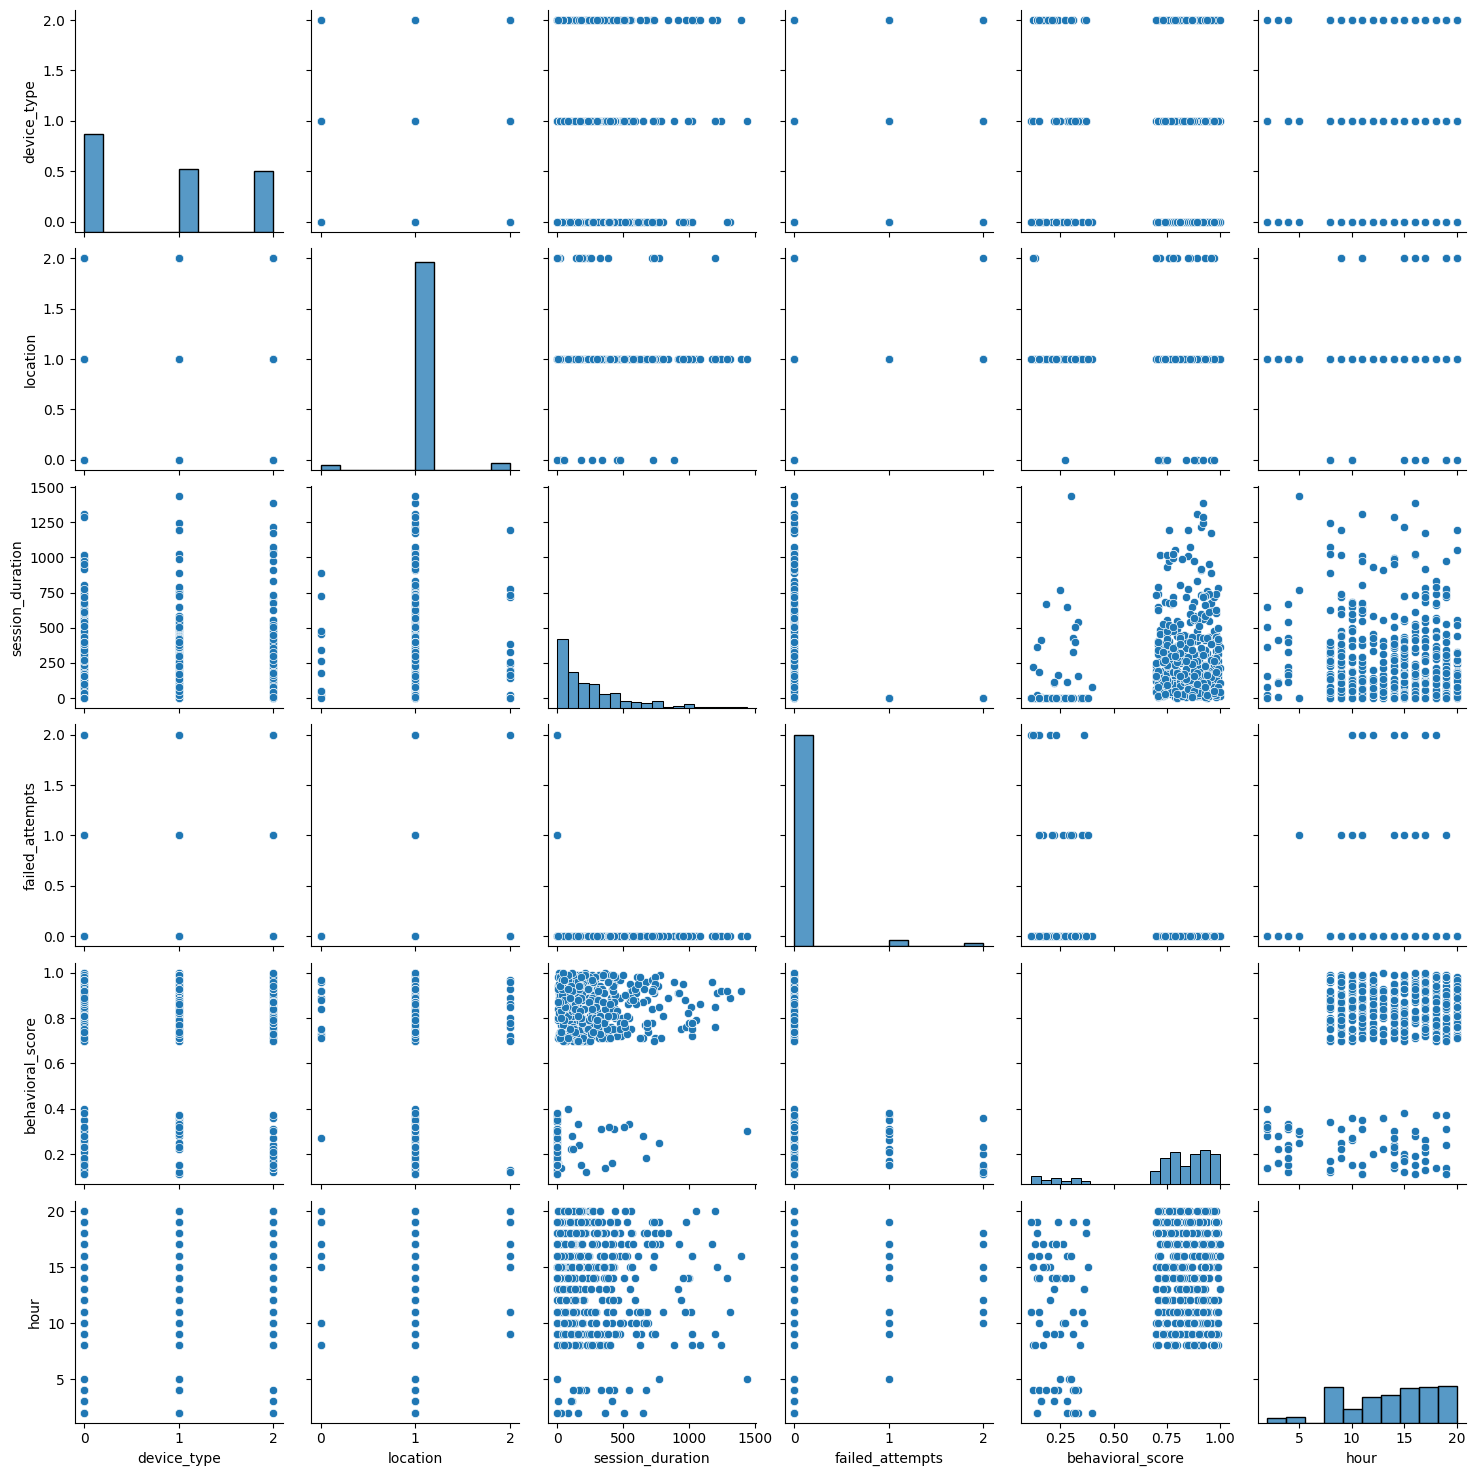

In [ ]:

# Visualize distributions
sns.pairplot(df[features])
plt.show()


In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


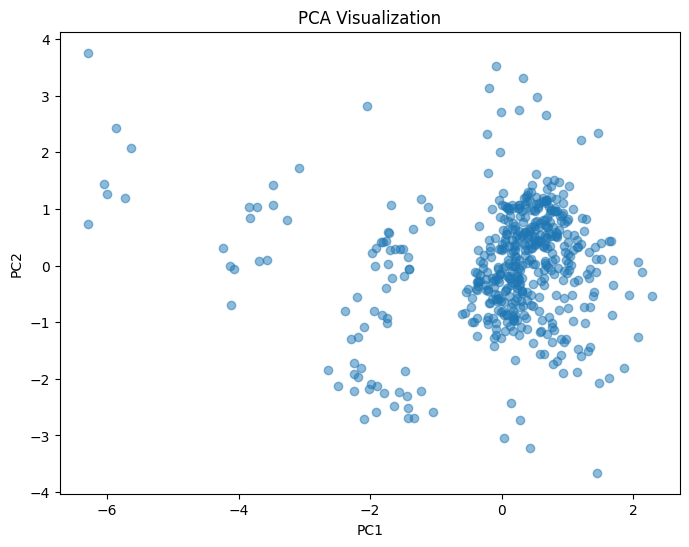

In [ ]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

In [ ]:

df['anomaly'] = model.fit_predict(X_scaled)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 for anomaly


In [ ]:

# Anomaly scores (higher score = more anomalous)
df['anomaly_score'] = -model.decision_function(X_scaled)  # Inverted to make higher = more risky

# Classify severity into Low, Medium, High
df['anomaly_severity'] = pd.qcut(df['anomaly_score'], q=[0, 0.33, 0.66, 1.0], labels=['Low', 'Medium', 'High'])

# Show sample
df[['user_id', 'timestamp', 'ip_address', 'anomaly', 'anomaly_score', 'anomaly_severity']].head()


,user_id,timestamp,ip_address,anomaly,anomaly_score,anomaly_severity
0,user_003,2025-06-22 10:11:59,103.69.126.55,0,-0.071855,Medium
1,user_015,2025-06-15 19:20:17,103.69.126.74,0,-0.036888,High
2,user_012,2025-06-11 08:25:04,202.45.157.220,0,-0.039381,High
3,user_036,2025-06-21 03:18:36,202.79.55.171,1,0.071053,High
4,user_032,2025-06-09 16:48:50,202.70.68.210,1,0.068943,High


In [ ]:

df.to_csv("unsupervised_anomaly_results.csv", index=False)


In [ ]:
import shutil

shutil.copy("/content/unsupervised_anomaly_results.csv", f"{target_dir}/unsupervised_anomaly_results.csv")


'/content/drive/MyDrive/ritee/unsupervised_anomaly_results.csv'